In [1]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py
import os
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

In [2]:
def printmd(string):
    display(Markdown(string))

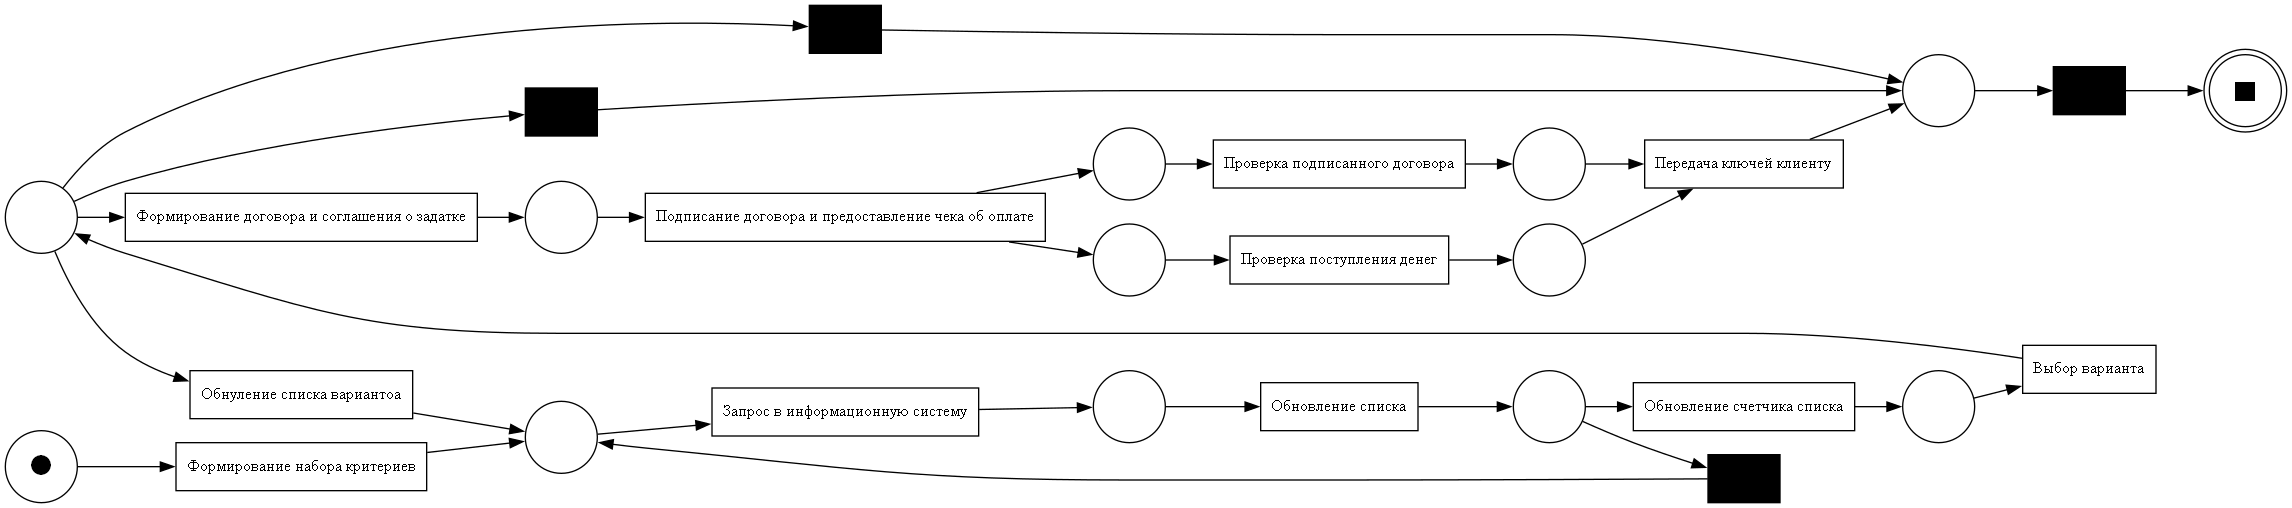

In [3]:
bpmn_graph2=pm4py.read_bpmn("C:/Users/pobud/PycharmProjects/pythonProject/python-virtual-environments/plan/Arend(NEW).bpmn")
net,im,fm=pm4py.convert_to_petri_net(bpmn_graph2)

gviz=pn_visualizer.apply(net,im,fm)
pn_visualizer.view(gviz)

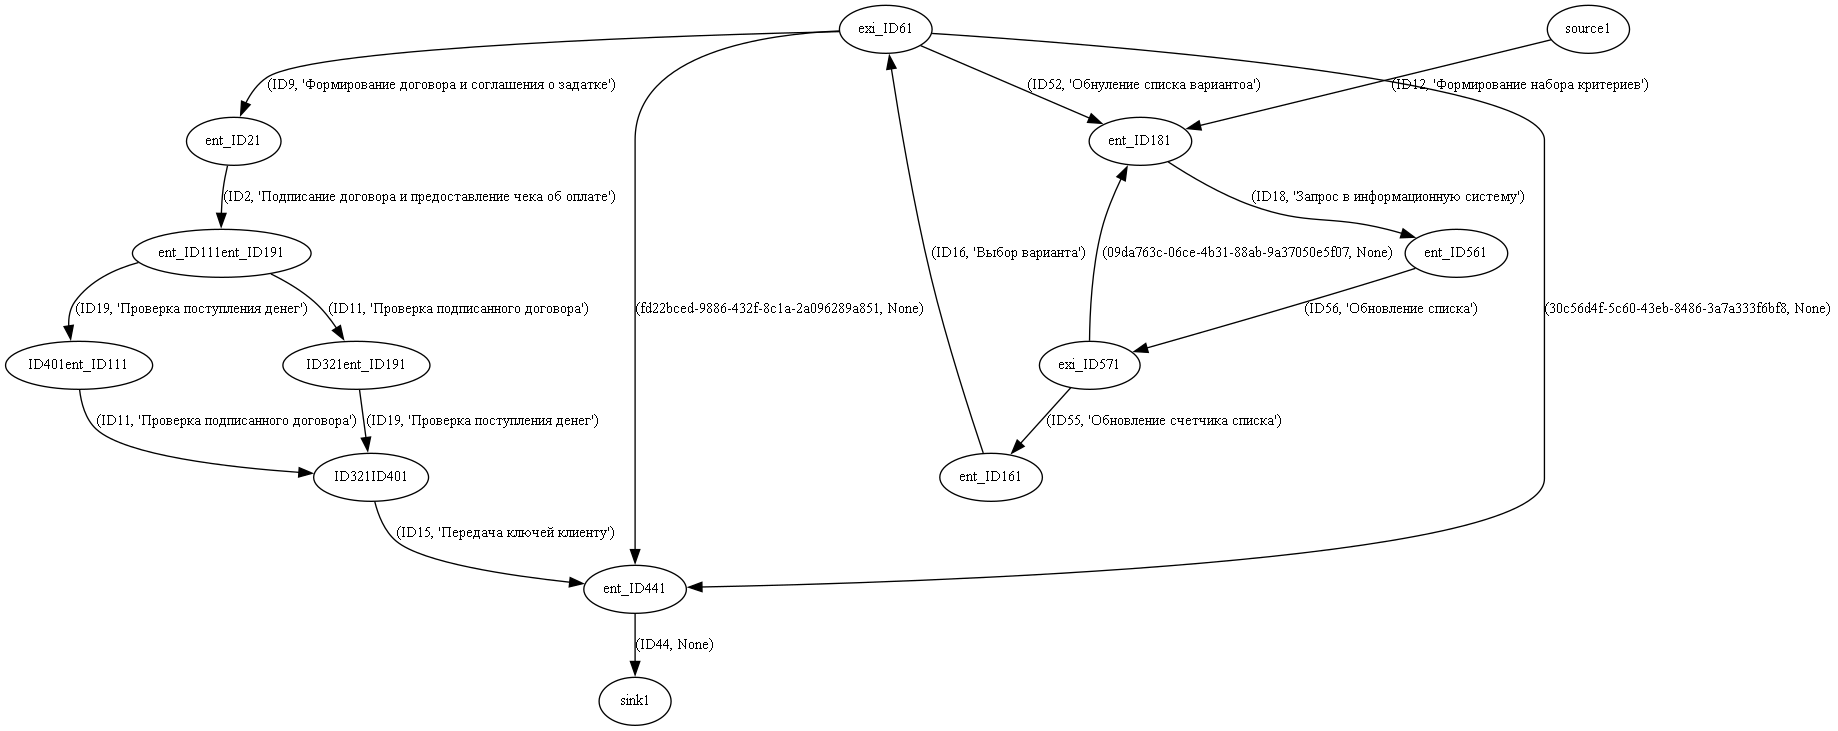

In [4]:
from pm4py.objects.petri_net.utils import reachability_graph
ts=reachability_graph.construct_reachability_graph(net,im)

from pm4py.visualization.transition_system import visualizer as ts_visualizer
gviz=ts_visualizer.apply(ts,parameters={ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT:"png"})
ts_visualizer.view(gviz)

In [5]:
from pm4py.algo.analysis.woflan import algorithm as woflan

is_sound=woflan.apply(net,im,fm,parameters={woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND:True,woflan.Parameters.PRINT_DIAGNOSTICS:True,woflan.Parameters.RETURN_DIAGNOSTICS:True})

print("Is Workflow net  sound?:")
print(is_sound)

Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.
Is Workflow net  sound?:
(True, {'s_c_net': places: [ ID32, ID40, ent_ID11, ent_ID16, ent_ID18, ent_ID19, ent_ID2, ent_ID44, ent_ID56, exi_ID57, exi_ID6, sink, source ]
transitions: [ (09da763c-06ce-4b31-88ab-9a37050e5f07, None), (30c56d4f-5c60-43eb-8486-3a7a333f6bf8, None), (ID11, 'Проверка подписанного договора'), (ID12, 'Формирование набора критериев'), (ID15, 'Передача ключей клиенту'), (ID16, 'Выбор варианта'), (ID18, 'Запрос в информационную систему'), (ID19, 'Проверка поступления денег'), (ID2, 'Подписание договора и предоставление чека об оплате'), (ID44, None), (ID52, 'Обнуление списка вариантоа'), (ID55, 'Обновление счетчика списка'), (ID56, 'Обновление списка'), (ID9, 'Формирование договора и соглашения о задатке'), (fd22bced-9886-432f-8c1a-2a096289a851, None), (short_circuited_transition, 'short_circuited_transition') ]
arcs: [ (09da763c-06ce-4b31-8

In [7]:
simulated_log = simulator.apply(net,im,variant=simulator.Variants.BASIC_PLAYOUT,
                                    parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: 50})
pm4py.write_xes(simulated_log, 'ArendLog.xes')
arendlog = pm4py.read_xes('ArendLog.xes')
arendlog

c:\users\pobud\pycharmprojects\pythonproject\venv\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


exporting log, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

,concept:name,time:timestamp,case:concept:name
0,Формирование набора критериев,1970-04-26 20:46:40,0
1,Запрос в информационную систему,1970-04-26 20:46:41,0
2,Обновление списка,1970-04-26 20:46:42,0
3,Запрос в информационную систему,1970-04-26 20:46:43,0
4,Обновление списка,1970-04-26 20:46:44,0
...,...,...,...
571,Формирование набора критериев,1970-04-26 20:56:11,49
572,Запрос в информационную систему,1970-04-26 20:56:12,49
573,Обновление списка,1970-04-26 20:56:13,49
574,Обновление счетчика списка,1970-04-26 20:56:14,49


In [8]:
dataframe = pd.DataFrame(arendlog)
dataframe = dataframe.rename(columns={"concept:name": "action", "time:timestamp": "datetime", "case:concept:name": "client"})
client_actions = ['Формирование набора критериев', 'Выбор варианта', 'Подписание договора и предоставление чека об оплате']
manager_actions = ['Запрос в информационную систему', 'Проверка подписанного договора', 'Передача ключей клиенту']
financial_department_actions = ['Проверка поступления денег']
document_generation_actions = ['Формирование договора и соглашения о задатке']
is_actions = ['Обновление списка', 'Обновление счетчика списка', 'Обнуление списка вариантов']
for i, row in dataframe.iterrows():
    dataframe.loc[i, 'client'] = f"Клиент {row['client']}"
    if row['action'] in client_actions:
        dataframe.loc[i, 'resource'] = 'Клиент'
    elif row['action'] in manager_actions:
        dataframe.loc[i, 'resource'] = 'Менеджер'
    elif row['action'] in financial_department_actions:
        dataframe.loc[i, 'resource'] = 'Финансовый отдел'
    elif row['action'] in document_generation_actions:
        dataframe.loc[i, 'resource'] = 'Формирование документа'
    elif row['action'] in is_actions:
        dataframe.loc[i, 'resource'] = 'Информационная система'

dataframe = dataframe[['client', 'action', 'resource', 'datetime']]
dataframe.to_csv('ArendLog.csv', index = False)

In [9]:
fn = 'ArendLog.csv'
events = pd.read_csv(fn)

events.columns = ['client', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()


,client,action,resource,datetime
0,Клиент 0,Формирование набора критериев,Клиент,1970-04-26 20:46:40
1,Клиент 0,Запрос в информационную систему,Менеджер,1970-04-26 20:46:41
2,Клиент 0,Обновление списка,Информационная система,1970-04-26 20:46:42
3,Клиент 0,Запрос в информационную систему,Менеджер,1970-04-26 20:46:43
4,Клиент 0,Обновление списка,Информационная система,1970-04-26 20:46:44


In [10]:
print('{} has {} rows and {} columns.'.format(fn, events.shape[0], events.shape[1]))


ArendLog.csv has 576 rows and 4 columns.


In [11]:
## Get the case start times to get the time deltas for the 'age' of each activity with respect to start
case_starts_ends = events.pivot_table(index='client', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['client', 'caseend', 'casestart']
events = events.merge(case_starts_ends, on='client')
events['relativetime'] = events['datetime'] - events['casestart']
events.head()

,client,action,resource,datetime,caseend,casestart,relativetime
0,Клиент 0,Формирование набора критериев,Клиент,1970-04-26 20:46:40,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:00
1,Клиент 0,Запрос в информационную систему,Менеджер,1970-04-26 20:46:41,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:01
2,Клиент 0,Обновление списка,Информационная система,1970-04-26 20:46:42,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:02
3,Клиент 0,Запрос в информационную систему,Менеджер,1970-04-26 20:46:43,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:03
4,Клиент 0,Обновление списка,Информационная система,1970-04-26 20:46:44,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:04


In [12]:
events['action'] = events['action'].apply(lambda x: x.strip())

In [13]:
delimiter = '___'

makeEventString = lambda x: delimiter.join(x)
makeEventString.__name__ = 'makeEventString'

numEvents = lambda x: len(x)
numEvents.__name__ = 'numEvents'


caselogs = events.pivot_table(index='client', aggfunc={'action': [makeEventString, numEvents]})
caselogs = caselogs.reset_index()
caselogs.columns = ['client', 'action_sequence', 'numactions']

events = pd.merge(events, caselogs, on='client')
events['caselength'] = events['caseend'] - events['casestart']

events.head()


,client,action,resource,datetime,caseend,casestart,relativetime,action_sequence,numactions,caselength
0,Клиент 0,Формирование набора критериев,Клиент,1970-04-26 20:46:40,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:00,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06
1,Клиент 0,Запрос в информационную систему,Менеджер,1970-04-26 20:46:41,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:01,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06
2,Клиент 0,Обновление списка,Информационная система,1970-04-26 20:46:42,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:02,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06
3,Клиент 0,Запрос в информационную систему,Менеджер,1970-04-26 20:46:43,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:03,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06
4,Клиент 0,Обновление списка,Информационная система,1970-04-26 20:46:44,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:04,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06


In [14]:
## Get day of week
events['weekday'] = events['datetime'].apply(lambda x: x.weekday())
events['date'] = events['datetime'].apply(lambda x: x.date())
events['startdate'] = events['casestart'].apply(lambda x: x.date())
events['hour'] = events['datetime'].apply(lambda x: x.time().hour)
## Get relative times in more friendly terms
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativedays'] = events['relativetime'].dt.days

In [15]:
events.head()

,client,action,resource,datetime,caseend,casestart,relativetime,action_sequence,numactions,caselength,weekday,date,startdate,hour,relativetime_s,relativedays
0,Клиент 0,Формирование набора критериев,Клиент,1970-04-26 20:46:40,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:00,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06,6,1970-04-26,1970-04-26,20,0,0
1,Клиент 0,Запрос в информационную систему,Менеджер,1970-04-26 20:46:41,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:01,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06,6,1970-04-26,1970-04-26,20,1,0
2,Клиент 0,Обновление списка,Информационная система,1970-04-26 20:46:42,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:02,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06,6,1970-04-26,1970-04-26,20,2,0
3,Клиент 0,Запрос в информационную систему,Менеджер,1970-04-26 20:46:43,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:03,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06,6,1970-04-26,1970-04-26,20,3,0
4,Клиент 0,Обновление списка,Информационная система,1970-04-26 20:46:44,1970-04-26 20:46:46,1970-04-26 20:46:40,0 days 00:00:04,Формирование набора критериев___Запрос в инфор...,7,0 days 00:00:06,6,1970-04-26,1970-04-26,20,4,0


# Visualisations

In [16]:
activities = list(events['action'].unique())
markers = ['*', '+', 'h', 'H', 'o', 'x', 'X', 'D', '^', 'v', 's']
assert(len(activities)==len(markers))

In [17]:
clients = events['client'].unique()
selected_clients = clients[0:50]
patientX = events[events['client'].isin(selected_clients)]



## Simple scatter plots

### Date

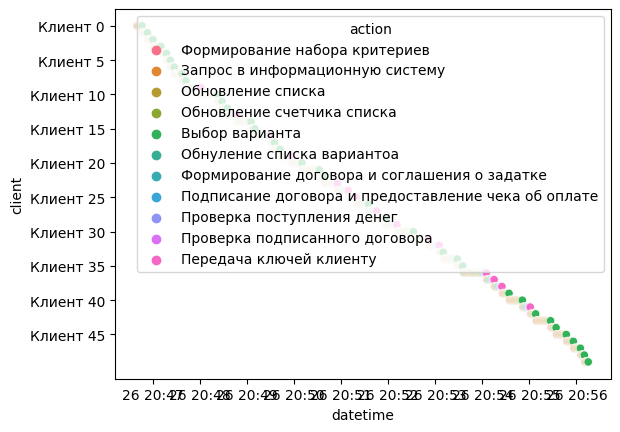

In [18]:
patientnums = [int(e) for e in events['client'].apply(lambda x: x.split()[1])]
resourcenums = [i for (i, e) in enumerate(events['resource'])]

ax = sns.scatterplot(x=events['datetime'], y=events['client'], hue=events['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

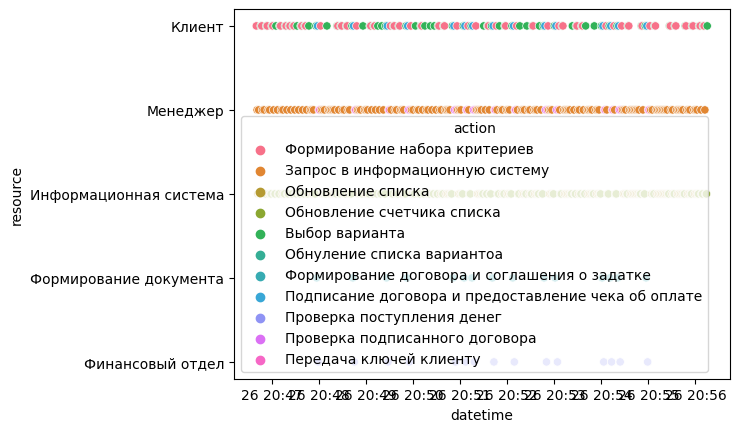

In [19]:
ax = sns.scatterplot(x=events['datetime'], y=events['resource'], hue=events['action'])

### Weekday

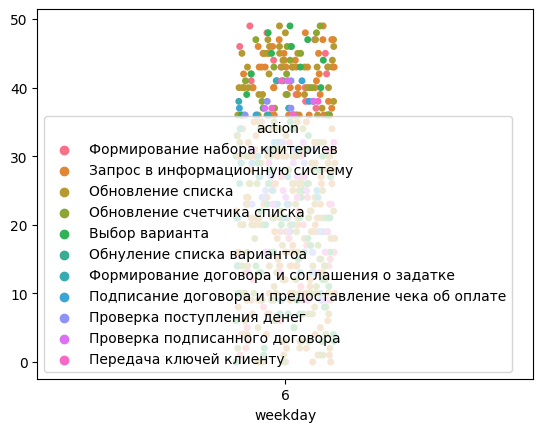

In [20]:
ax = sns.stripplot(x=events['weekday'], y=patientnums, hue=events['action'])

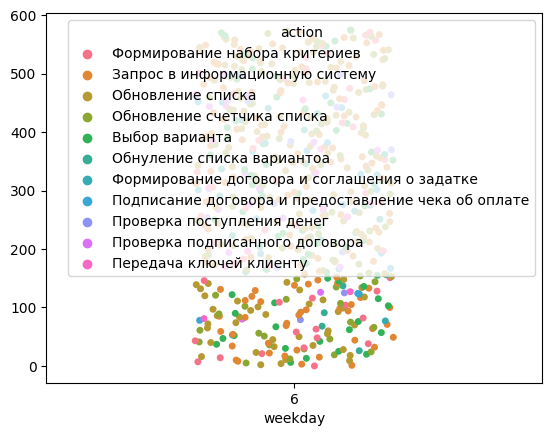

In [21]:
ax = sns.stripplot(x=events['weekday'], y=resourcenums, hue=events['action'], jitter=0.2)

### Hour

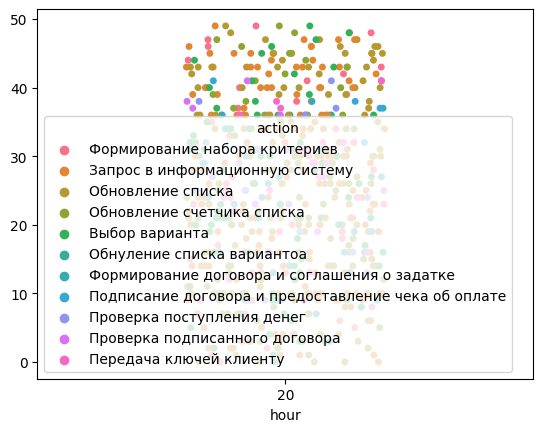

In [22]:
ax = sns.stripplot(x=events['hour'], y=patientnums, hue=events['action'], jitter=0.2)


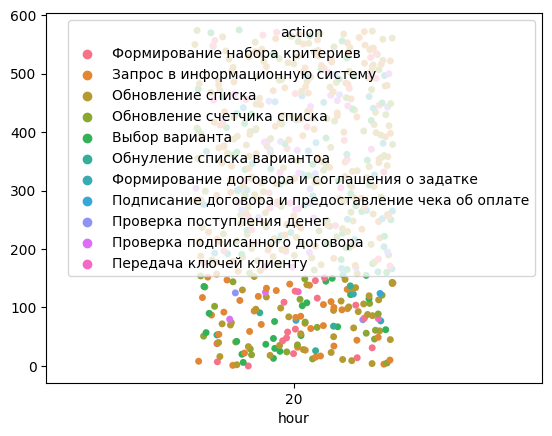

In [23]:
ax = sns.stripplot(x=events['hour'], y=resourcenums, hue=events['action'], jitter=0.2)

### Relative time 
Time since start of case

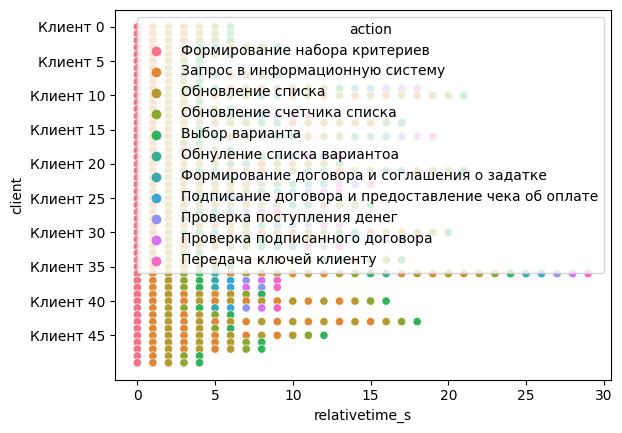

In [24]:
## Time in seconds
#ax = sns.scatterplot(x=events['relativetime'].dt.seconds, y=events['patient'], hue=events['action'])
#plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

## Time in hours
ax = sns.scatterplot(x=events['relativetime_s'], y=events['client'], hue=events['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));


In [25]:
ordered = events.sort_values(by=['caselength', 'client', 'relativetime_s'])

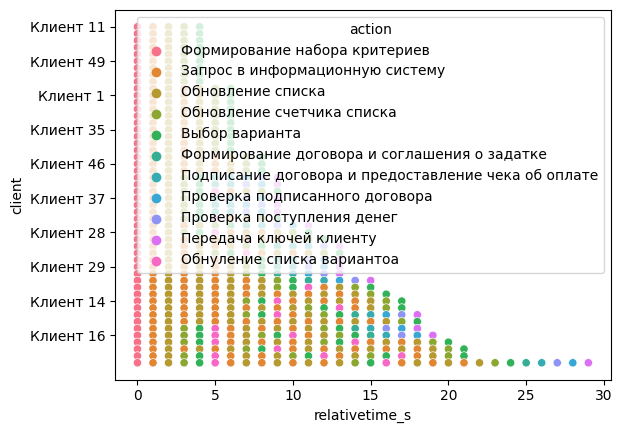

In [26]:
## Time in seconds
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['client'], hue=ordered['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
plt.show()


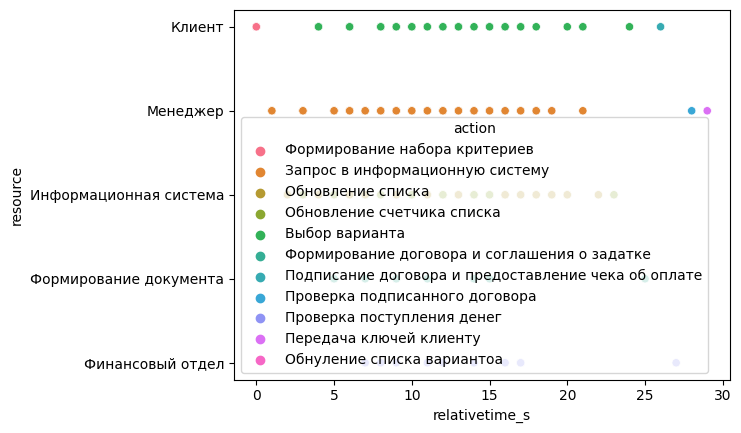

In [27]:
## Resources
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['resource'], hue=ordered['action'])
plt.show()


In [28]:
#pd.crosstab(events['action'], events['resource'])
pd.crosstab(events['action'], events['resource'], normalize='columns')
#pd.crosstab(events['action'], events['resource'], normalize='index')

resource,Информационная система,Клиент,Менеджер,Финансовый отдел,Формирование документа
action,,,,,
Выбор варианта,0.000000,0.514925,0.000000,0.0,0.0
Запрос в информационную систему,0.000000,0.000000,0.830508,0.0,0.0
Обновление списка,0.680556,0.000000,0.000000,0.0,0.0
Обновление счетчика списка,0.319444,0.000000,0.000000,0.0,0.0
Передача ключей клиенту,0.000000,0.000000,0.084746,0.0,0.0
Подписание договора и предоставление чека об оплате,0.000000,0.111940,0.000000,0.0,0.0
Проверка подписанного договора,0.000000,0.000000,0.084746,0.0,0.0
Проверка поступления денег,0.000000,0.000000,0.000000,1.0,0.0
Формирование договора и соглашения о задатке,0.000000,0.000000,0.000000,0.0,1.0


### Relative day

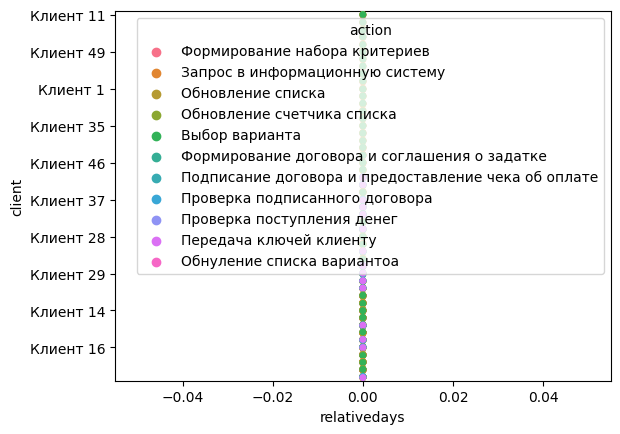

In [29]:
## Days
ax = sns.stripplot(x=ordered['relativedays'], y=ordered['client'], hue=ordered['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
plt.show()


## Discrete event plot
* y-axis represents each patient case.
* x-axis represents time since case was initiated.
* Different marker shapes represent different types of cases.

In [30]:
## Widget libraries
from ipywidgets import widgets
from ipywidgets import interact, interact_manual

patients = events['client'].unique()

@interact
def getCaseData(x=patients):
    return events[events['client']==x]



interactive(children=(Dropdown(description='x', options=('Клиент 0', 'Клиент 1', 'Клиент 2', 'Клиент 3', 'Клие…

In [31]:
patientX = getCaseData(patients[10])

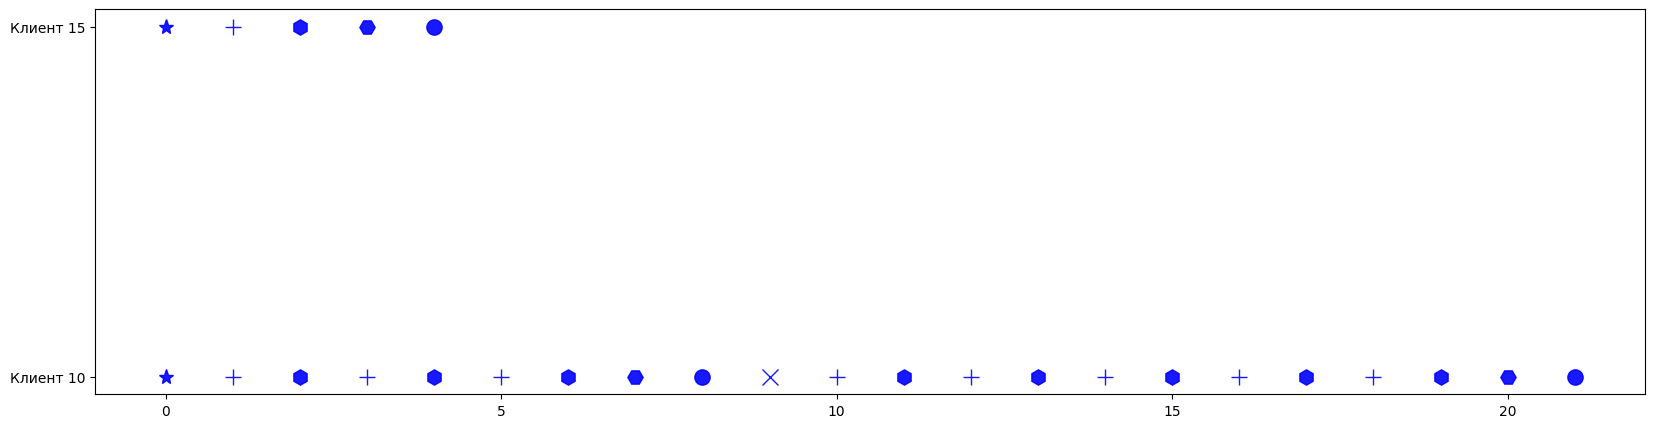

In [32]:
def getEventPlot(patientlist=[patients[10], patients[15]]):
    fig, ax = plt.subplots(figsize=(20, 5))
    
    for x in patientlist:
        patientX = getCaseData(x)
        
    
        for i in range(0, len(activities)):
            a = activities[i]
            marker = markers[i]
            selected = patientX[patientX['action']==a]
            ax.plot(selected['relativetime_s'], 
                selected['client'],
                marker=marker, markersize=11,
                alpha=0.9, color='blue', linewidth=0, 
                label=a);
    plt.show()

getEventPlot()


## Most frequent event sequence

In [33]:
most_frequent_event = events['action_sequence'].value_counts().idxmax()


printmd('**The most frequent event (sequence) has** {} **activities.**'.format(len(most_frequent_event.split(delimiter))))
printmd('**The activity sequence is**:  {}.'.format(', '.join(most_frequent_event.split(delimiter))))

**The most frequent event (sequence) has** 7 **activities.**

**The activity sequence is**:  Формирование набора критериев, Запрос в информационную систему, Обновление списка, Запрос в информационную систему, Обновление списка, Обновление счетчика списка, Выбор варианта.

## Filtering events

Диграмма событий для всех процессов

**The following actions are common to all cases**: Формирование набора критериев

**The following actions are the ones that we wish to keep (not common to all cases)**: Выбор варианта, Запрос в информационную систему, Обновление списка, Обновление счетчика списка, Обнуление списка вариантоа, Передача ключей клиенту, Подписание договора и предоставление чека об оплате, Проверка подписанного договора, Проверка поступления денег, Формирование договора и соглашения о задатке

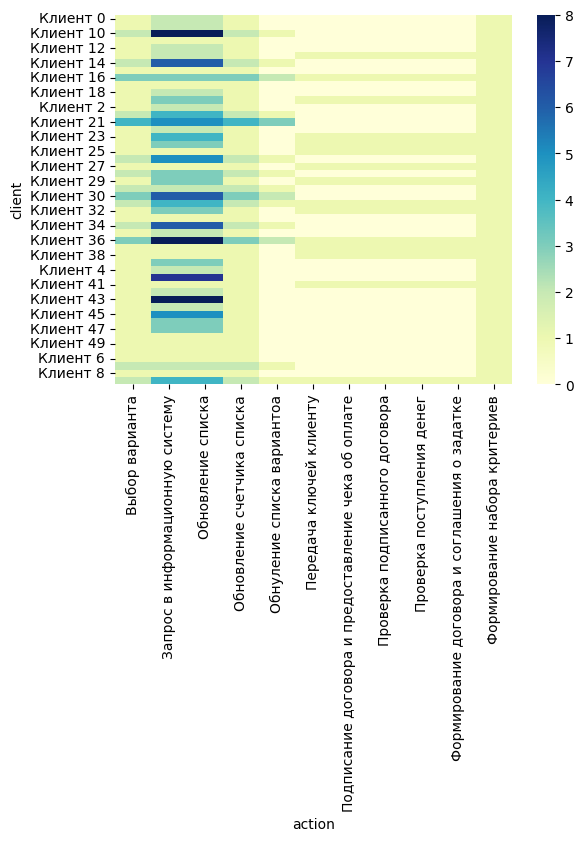

In [34]:
## Visualise which events are common to patients
patient_events = pd.crosstab(events['client'], events['action'])
sns.heatmap(patient_events, cmap="YlGnBu")

nunique = patient_events.apply(pd.Series.nunique)
shared_actions = nunique[nunique==1].index
actions_to_keep = nunique[nunique>1].index
printmd('**The following actions are common to all cases**: {}'.format(', '.join(shared_actions)))
printmd('**The following actions are the ones that we wish to keep (not common to all cases)**: {}'.format(', '.join(actions_to_keep)))


In [35]:
#filtered = events[events['action']=='X-ray scan']
filtered = events[events['action'].isin(actions_to_keep)]
printmd('**The filtered data has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

filtered = filtered[filtered['action']!='X-ray scan']
printmd('**The filtered data excluding X-rays has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

filtered = filtered[~filtered['resource'].isin([' Team 1', ' Team 2'])]
printmd('**The filtered data excluding team 1 and team 2 has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

patient_events = pd.crosstab(filtered['client'], filtered['action'])
#sns.heatmap(patient_events, cmap="YlGnBu")

**The filtered data has** 526 **rows and** 16 **columns.**

**The filtered data excluding X-rays has** 526 **rows and** 16 **columns.**

**The filtered data excluding team 1 and team 2 has** 526 **rows and** 16 **columns.**

In [36]:
printmd('**The filtered data has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))
printmd('**This amounts to** {} **cases with** {} **distinct actions.**'.format(patient_events.shape[0], patient_events.shape[1]))
printmd('**There are** {} **events.**'.format(np.sum(np.array(patient_events))))

**The filtered data has** 526 **rows and** 16 **columns.**

**This amounts to** 50 **cases with** 10 **distinct actions.**

**There are** 526 **events.**

## Process Mining
* Check out this [introduction to process mining in Python](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5).
* [Documentation for pm4py](https://pm4py.fit.fraunhofer.de/)

In [37]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [38]:
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'datetime': 'time:timestamp', 'client': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)

pm4py.write_xes(simulated_log,'ArendLog.xes')


exporting log, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

### Alpha miner

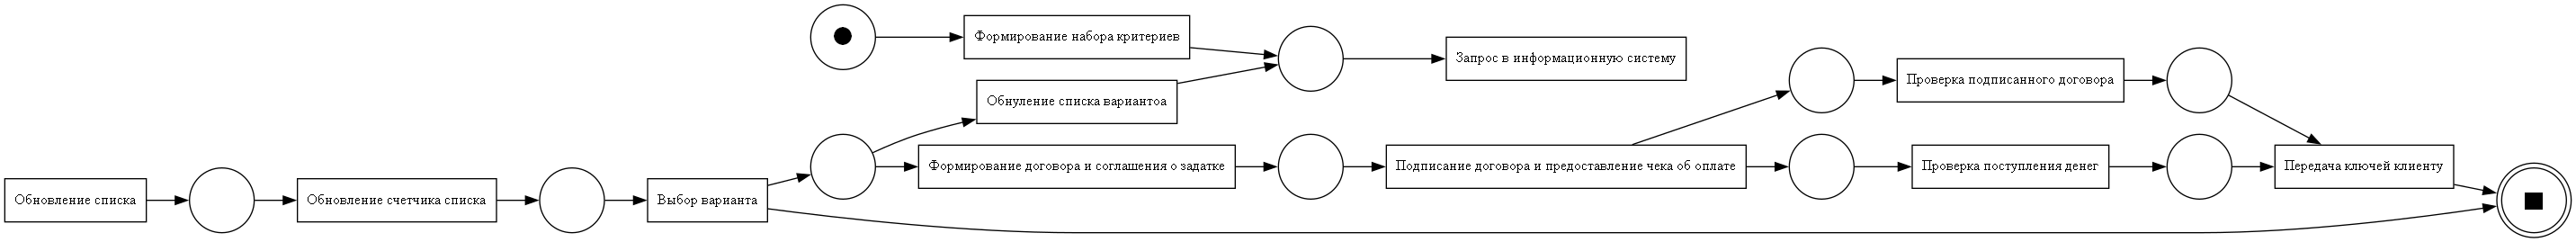

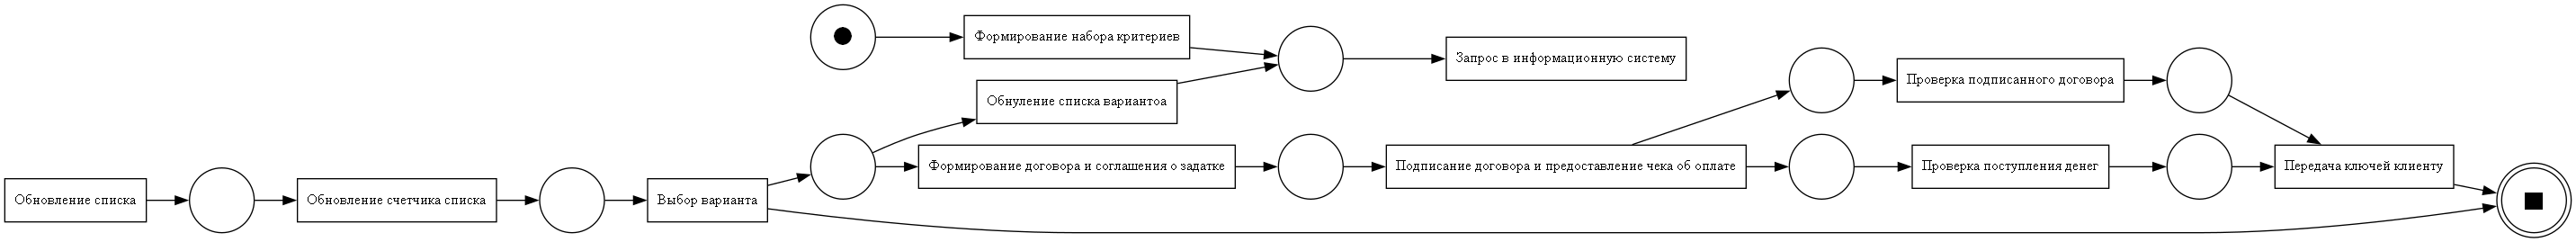

In [39]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)
net2, initial_marking2, final_marking2 = alpha_miner.apply(simulated_log)


# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

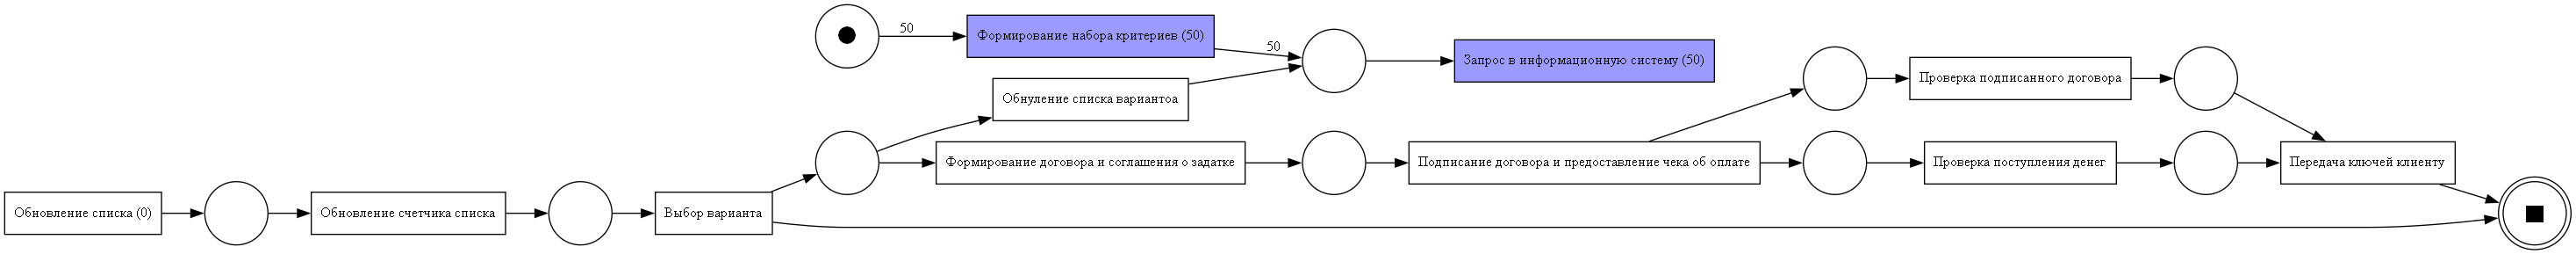

In [40]:
# add information about frequency to the viz 
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# save the Petri net
pn_visualizer.save(gviz, "alpha_miner.png")
pn_visualizer.view(gviz)

График прямого следования

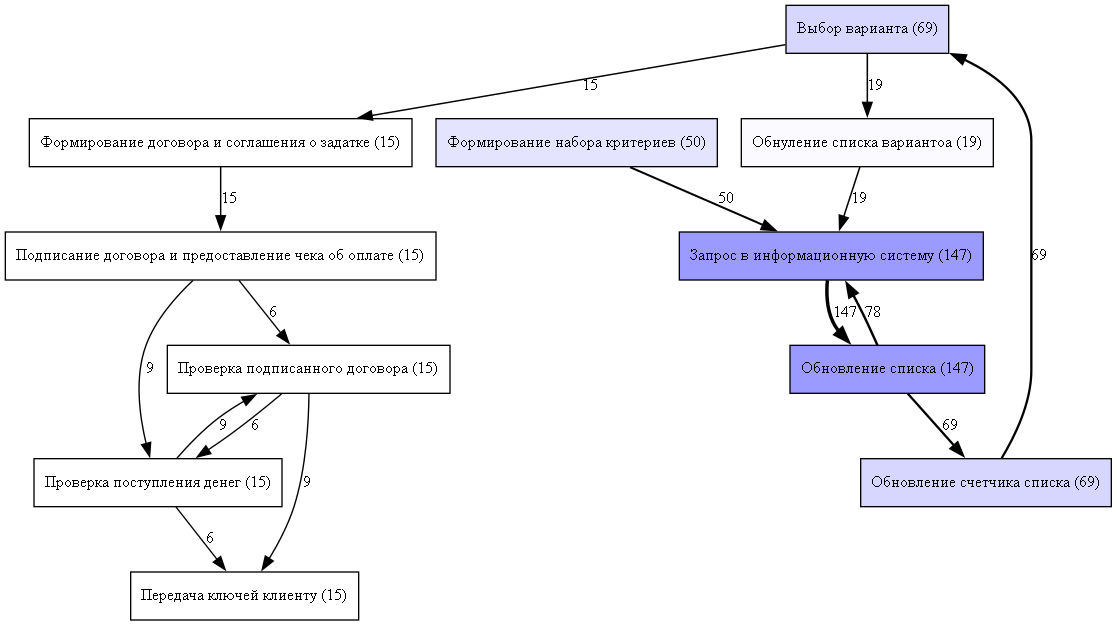

In [41]:
#Create graph from log
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

График со средней производительностью

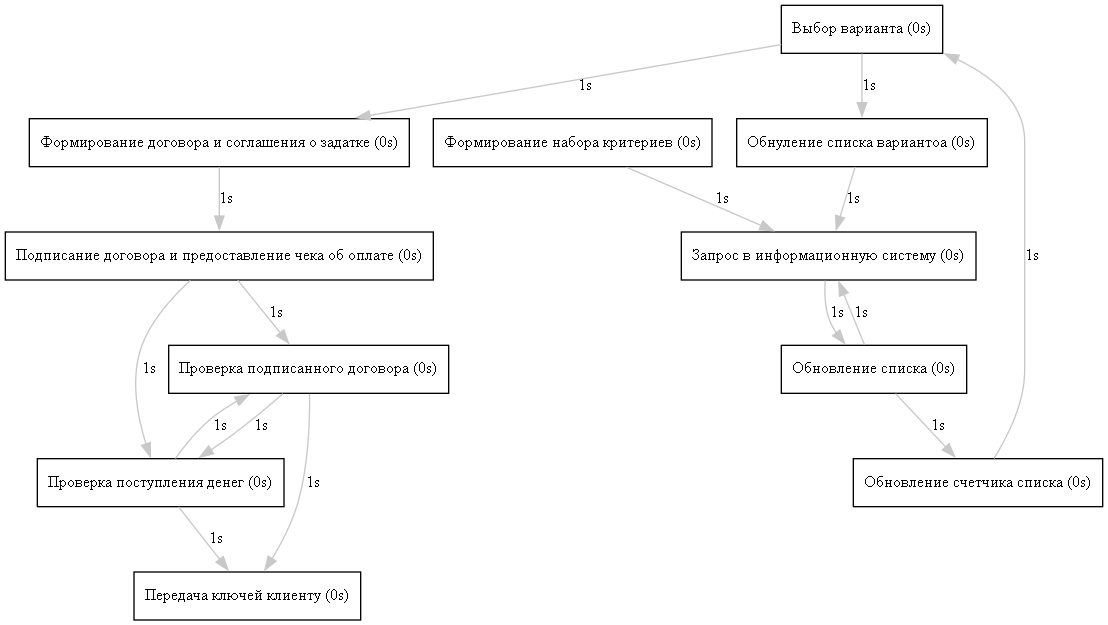

In [42]:
# creatig the graph from log
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

### Heuristic miner

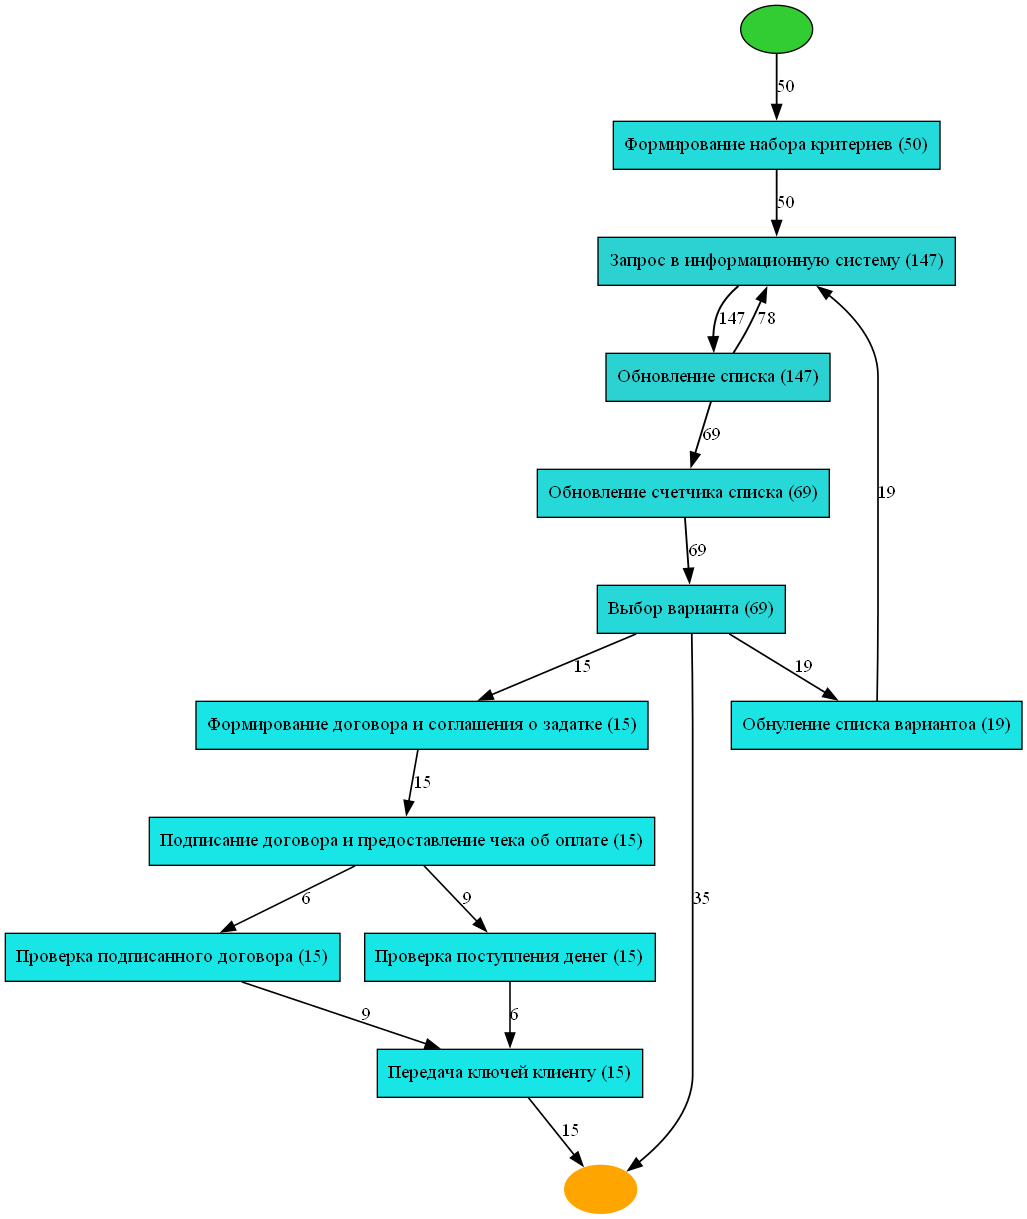

In [43]:
# heuristics miner
heu_net = heuristics_miner.apply_heu(log)

# viz
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

Petri-net of heuristic miner output

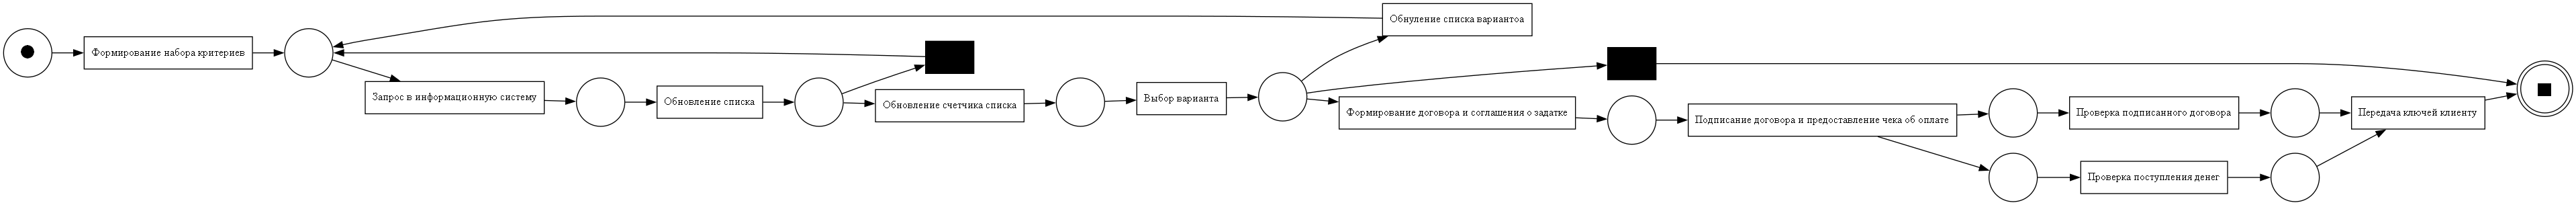

In [44]:
# heuristics miner
net, im, fm = heuristics_miner.apply(log)

# viz
gviz = pn_visualizer.apply(net, im, fm)

#pn_visualizer.view(gviz)
pn_visualizer.view(gviz)

### Inductive miner

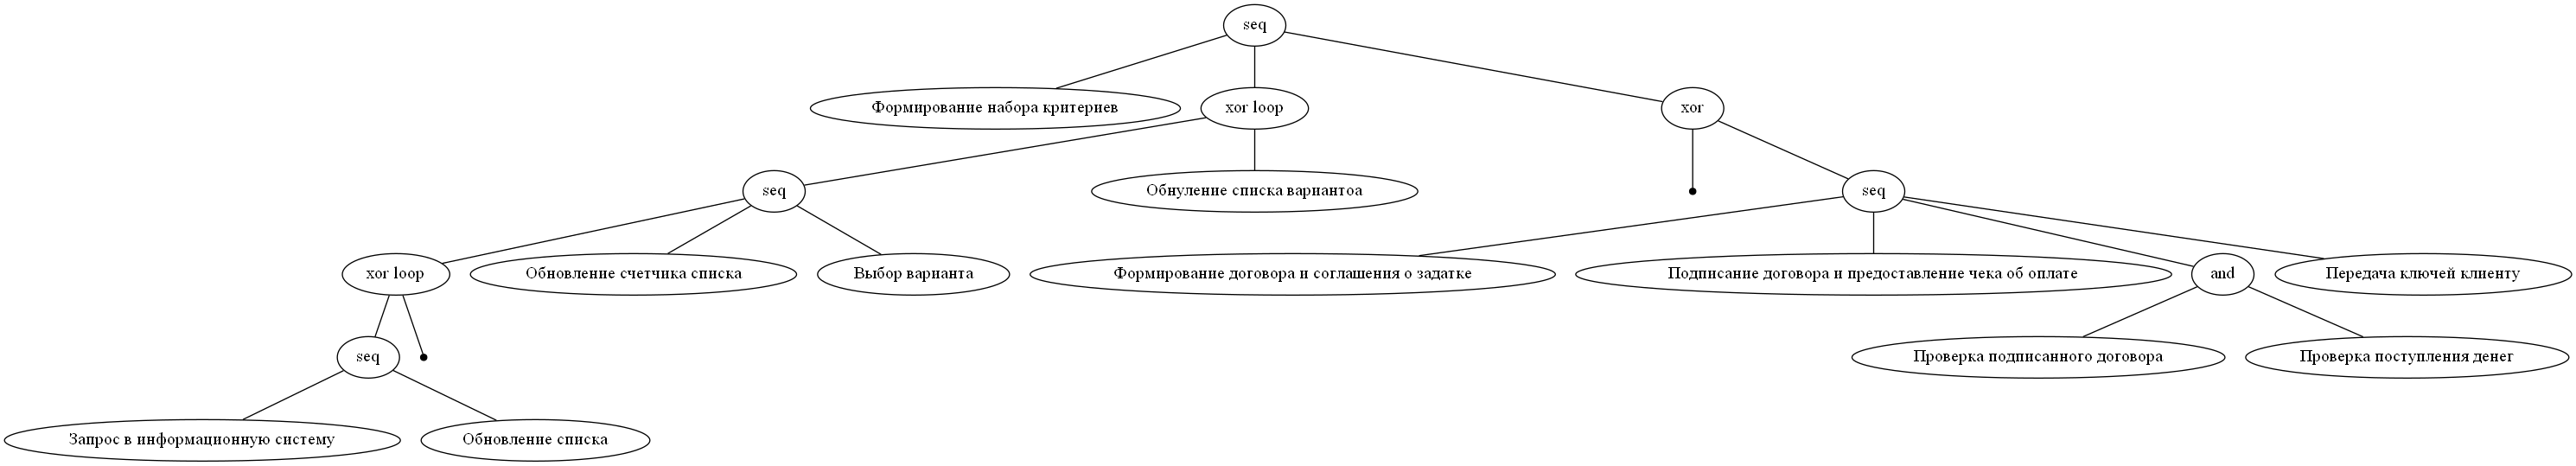

In [45]:
# create the process tree
tree = inductive_miner.apply(log)

# viz
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

In [50]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as calculate_precision

In [51]:
net_heu, in_mark_heu, fi_mark_heu = heuristics_miner.apply(log)
replayed_traces1_token = pm4py.conformance_diagnostics_token_based_replay(log, net_heu, in_mark_heu, fi_mark_heu)

log_fitness = replay_fitness.evaluate(replayed_traces1_token, variant=replay_fitness.Variants.TOKEN_BASED)
log_precision = calculate_precision.apply(log, net=net_heu, marking=in_mark_heu, final_marking=fi_mark_heu,
                                          variant=calculate_precision.Variants.ETCONFORMANCE_TOKEN)

print(f'Fitness: {log_fitness}')
print(f'Precision: {log_precision}')

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

Fitness: {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Precision: 0.9559585492227979


In [52]:
replayed_traces1_align = pm4py.conformance_diagnostics_alignments(log, net_heu, in_mark_heu, fi_mark_heu)

log_fitness = replay_fitness.evaluate(replayed_traces1_align, variant=replay_fitness.Variants.ALIGNMENT_BASED)
log_precision = calculate_precision.apply(log, net=net_heu, marking=in_mark_heu, final_marking=fi_mark_heu,
                                          variant=calculate_precision.Variants.ALIGN_ETCONFORMANCE)

print(f'Fitness: {log_fitness}')
print(f'Precision: {log_precision}')

aligning log, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

Fitness: {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999863196954013}
Precision: 0.9559585492227979


In [53]:
net_al, in_mark_al, fi_mark_al = alpha_miner.apply(log)
replayed_traces1_token = pm4py.conformance_diagnostics_token_based_replay(log, net_al, in_mark_al, fi_mark_al)

log_fitness = replay_fitness.evaluate(replayed_traces1_token, variant=replay_fitness.Variants.TOKEN_BASED)
log_precision = calculate_precision.apply(log, net=net_al, marking=in_mark_al, final_marking=fi_mark_al,
                                          variant=calculate_precision.Variants.ETCONFORMANCE_TOKEN)

print(f'Fitness: {log_fitness}')
print(f'Precision: {log_precision}')

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

Fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.7993505100707113, 'log_fitness': 0.7905020099093203, 'percentage_of_fitting_traces': 0.0}
Precision: 0.5677655677655677


In [54]:
replayed_traces1_align = pm4py.conformance_diagnostics_alignments(log, net_al, in_mark_al, fi_mark_al)

log_fitness = replay_fitness.evaluate(replayed_traces1_align, variant=replay_fitness.Variants.ALIGNMENT_BASED)
log_precision = calculate_precision.apply(log, net=net_al, marking=in_mark_al, final_marking=fi_mark_al,
                                          variant=calculate_precision.Variants.ALIGN_ETCONFORMANCE)

print(f'Fitness: {log_fitness}')
print(f'Precision: {log_precision}')

aligning log, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

Fitness: {'percFitTraces': 0.0, 'averageFitness': 0.6368955286098221, 'percentage_of_fitting_traces': 0.0, 'average_trace_fitness': 0.6368955286098221, 'log_fitness': 0.6004319654427646}
Precision: 0.5677655677655677


In [55]:
net_in, in_mark_in, fi_mark_in = pt_converter.apply(tree)
replayed_traces1_token = pm4py.conformance_diagnostics_token_based_replay(log, net_in, in_mark_in, fi_mark_in)

log_fitness = replay_fitness.evaluate(replayed_traces1_token, variant=replay_fitness.Variants.TOKEN_BASED)
log_precision = calculate_precision.apply(log, net=net_in, marking=in_mark_in, final_marking=fi_mark_in,
                                          variant=calculate_precision.Variants.ETCONFORMANCE_TOKEN)

print(f'Fitness: {log_fitness}')
print(f'Precision: {log_precision}')

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

Fitness: {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Precision: 0.9559585492227979


In [56]:
replayed_traces1_align = pm4py.conformance_diagnostics_alignments(log, net_in, in_mark_in, fi_mark_in)

log_fitness = replay_fitness.evaluate(replayed_traces1_align, variant=replay_fitness.Variants.ALIGNMENT_BASED)
log_precision = calculate_precision.apply(log, net=net_in, marking=in_mark_in, final_marking=fi_mark_in,
                                          variant=calculate_precision.Variants.ALIGN_ETCONFORMANCE)

print(f'Fitness: {log_fitness}')
print(f'Precision: {log_precision}')

aligning log, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/140 [00:00<?, ?it/s]

Fitness: {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999719133429781}
Precision: 0.9559585492227979


Petri-net of inductive miner output